In [1]:
import itertools as itr
import os
from tqdm import tqdm
from collections import defaultdict

import causaldag as cd
from strategies.simulator import IterationData
from strategies.information_gain import create_info_gain_strategy_dag_collection, create_info_gain_strategy
from strategies.random_nodes import random_strategy

from utils import graph_utils
from analysis.check_gies import get_parent_probs_by_dag, get_l1_score

from config import DATA_FOLDER
samples_folder = os.path.join(DATA_FOLDER, 'check-interventions', 'samples')
os.makedirs(samples_folder, exist_ok=True)

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set()

from scipy.special import logsumexp

from pprint import PrettyPrinter
pp = PrettyPrinter()

In [2]:
import numpy as np
import xarray as xr
from sklearn import preprocessing

In [3]:
IV_STRENGTH = 5
nnodes = 20
density = .5
target = int(np.ceil(nnodes/2))
nsamples = 2000
N_BOOT = 100
runs = 3
nsamples_obs = 1000
target

10

In [4]:
def tuplify(s):
    a, b = s.split(',')
    return (int(a), int(b))

def detuplify(t):
    a, b = t
    return '%s,%s' % (a, b)

print(tuplify('1,2'))
print(detuplify((1, 2)))

(1, 2)
1,2


In [5]:
np.random.seed(0)
true_dag = cd.rand.directed_erdos(nnodes, density)
true_arcs = {(i+1, i) for i in range(target)} | {(i, i+1) for i in range(target, nnodes-1)}
# true_arcs = {(i+1, i) for i in range(nnodes-1)}
true_dag = cd.DAG(nodes=set(range(nnodes)), arcs=true_arcs)
true_dag.arcs

{(1, 0),
 (2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 9),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19)}

In [6]:
# true_cpdag = true_dag.interventional_cpdag({5}, cpdag=true_dag.cpdag())
true_cpdag = true_dag.cpdag()
true_dag_mec = [cd.DAG(nodes=set(range(nnodes)), arcs=arcs) for arcs in true_cpdag.all_dags()]
intervention_weights = defaultdict(int)
for iv in range(nnodes):
    for poss_dag in true_dag_mec:
        poss_icpdag = poss_dag.interventional_cpdag({iv}, cpdag=true_cpdag)
        intervention_weights[iv] += len(poss_icpdag.arcs) - len(true_cpdag.arcs)
print(intervention_weights)

defaultdict(<class 'int'>, {0: 38, 1: 74, 2: 106, 3: 134, 4: 158, 5: 178, 6: 194, 7: 206, 8: 214, 9: 218, 10: 218, 11: 214, 12: 206, 13: 194, 14: 178, 15: 158, 16: 134, 17: 106, 18: 74, 19: 38})


In [7]:
arcs = {(i, j): 1 for i, j in true_dag.arcs}
gdag = cd.GaussDAG(nodes=list(range(nnodes)), arcs=arcs)
obs_samples_unscaled = gdag.sample(nsamples_obs)
obs_samples = [preprocessing.scale(gdag.sample(nsamples_obs)) for run in range(runs)]
np.diag(np.cov(obs_samples[0], rowvar=False))

array([1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001])

## Plot the graph

In [8]:
def draw_colored(gdag):
    cmap = plt.get_cmap('seismic')
    
    nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
    colorbar_ax = plt.subplot2grid((10, 10), (2, 9), rowspan=6)
    
    plt.gcf().set_size_inches(10, 10)
    d = nx.DiGraph()
    for (i, j), w in gdag.arc_weights.items():
        d.add_edge(i, j, weight=w)
    pos = graphviz_layout(d, 'dot')
    edges = d.edges()
    edge_colors = [(cmap((d[i][j]['weight']+1)/2)) for i, j in edges]
    nx.draw(d, pos=pos, node_color='w', edge_color=edge_colors, ax=nw_ax)
    nx.draw_networkx_labels(d, pos, labels={node: node for node in range(10)}, ax=nw_ax);
    
    cb = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=cmap, orientation='vertical')
    cb.set_ticks([0, .5, 1])
    cb.set_ticklabels([-1, 0, 1])

[10][11|10][12|11][13|12][14|13][15|14][16|15][17|16][18|17][19|18][9|10][8|9][7|8][6|7][5|6][4|5][3|4][2|3][1|2][0|1]


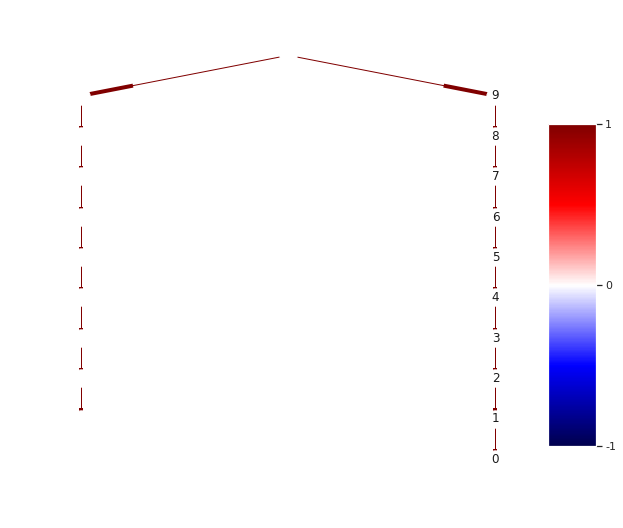

In [9]:
draw_colored(gdag)
print(str(gdag))

In [10]:
g = nx.Graph()
cpdag = true_dag.cpdag()
cpdag.edges

{(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19)}

In [11]:
for iv in range(10):
    icpdag = true_dag.interventional_cpdag({iv}, cpdag=cpdag)
    print(iv, ':', icpdag.edges)

0 : {(10, 11), (5, 6), (4, 5), (9, 10), (8, 9), (15, 16), (14, 15), (2, 3), (18, 19), (11, 12), (16, 17), (17, 18), (1, 2), (6, 7), (12, 13), (13, 14), (3, 4), (7, 8)}
1 : {(10, 11), (5, 6), (4, 5), (9, 10), (8, 9), (15, 16), (14, 15), (2, 3), (18, 19), (11, 12), (16, 17), (17, 18), (6, 7), (12, 13), (13, 14), (3, 4), (7, 8)}
2 : {(10, 11), (5, 6), (4, 5), (9, 10), (8, 9), (15, 16), (14, 15), (18, 19), (11, 12), (16, 17), (17, 18), (6, 7), (12, 13), (13, 14), (3, 4), (7, 8)}
3 : {(7, 8), (16, 17), (17, 18), (10, 11), (6, 7), (12, 13), (13, 14), (5, 6), (4, 5), (9, 10), (8, 9), (15, 16), (14, 15), (18, 19), (11, 12)}
4 : {(7, 8), (16, 17), (17, 18), (10, 11), (6, 7), (12, 13), (13, 14), (5, 6), (9, 10), (8, 9), (15, 16), (14, 15), (18, 19), (11, 12)}
5 : {(7, 8), (16, 17), (17, 18), (10, 11), (6, 7), (12, 13), (13, 14), (9, 10), (8, 9), (15, 16), (14, 15), (18, 19), (11, 12)}
6 : {(7, 8), (16, 17), (17, 18), (10, 11), (12, 13), (13, 14), (9, 10), (8, 9), (15, 16), (14, 15), (18, 19), (1

In [12]:
intervention_nodes = list(range(nnodes))
interventions = [
    cd.BinaryIntervention(
        intervention1=cd.ConstantIntervention(val=-IV_STRENGTH*std),
        intervention2=cd.ConstantIntervention(val=IV_STRENGTH*std),
    ) for std in np.diag(gdag.covariance)**.5
]
print(intervention_nodes)
pp.pprint(interventions)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[BinaryIntervention(intervention1=ConstantIntervention(val=-16.583123951776997), intervention2=ConstantIntervention(val=16.583123951776997), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-15.811388300841898), intervention2=ConstantIntervention(val=15.811388300841898), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-15.0), intervention2=ConstantIntervention(val=15.0), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-14.142135623730951), intervention2=ConstantIntervention(val=14.142135623730951), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-13.228756555322953), intervention2=ConstantIntervention(val=13.228756555322953), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-12.24744871391589), intervention2=ConstantIntervention(val=12.24744871391589), p=0.5),
 BinaryIntervention(intervention1=ConstantIntervention(val=-11.18

In [13]:
ivs2dags = defaultdict(list)

# Collect DAGs given just observational data

In [14]:
for run in tqdm(range(runs)):
    folder = os.path.join(samples_folder, 'observational,run%d' % run)
    os.makedirs(folder)
    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')

    graph_utils._write_data({-1: obs_samples[run]}, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)
    amats, dags = graph_utils._load_dags(gies_dags_folder)

    ivs2dags[-1].append(dags)

  0%|          | 0/3 [00:00<?, ?it/s]


FileExistsError: [Errno 17] File exists: '/home/ubuntu/active_learning/new/data/check-interventions/samples/observational,run0'

# Collect DAGs given interventional data

In [ ]:
for iv_node, intervention in tqdm(zip(intervention_nodes, interventions), total=len(interventions)):
    for run in range(runs):
        samples = gdag.sample_interventional({iv_node: intervention}, nsamples)
        samples = preprocessing.scale(samples)
        all_samples = {-1: obs_samples[run], iv_node: samples}
        folder = os.path.join(samples_folder, 'iv=%d,run%d' % (iv_node, run))
        os.makedirs(folder)

        samples_file = os.path.join(folder, 'samples.csv')
        interventions_folder = os.path.join(folder, 'interventions')
        gies_dags_folder = os.path.join(folder, 'gies_dags/')
        graph_utils._write_data(all_samples, samples_file, interventions_folder)
        graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

        amats, dags = graph_utils._load_dags(gies_dags_folder)
        ivs2dags[iv_node].append(dags)

# Count the occurrences of each arc in the sampled DAGs

In [ ]:
ivs2parent_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(gdag.nodes), runs]),
    dims=['iv_node', 'parent', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'parent': gdag.nodes,
        'run': list(range(runs))
    }
)
possible_arcs = list(itr.permutations(gdag.nodes, 2))
ivs2arc_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(possible_arcs), runs]),
    dims=['iv_node', 'arc', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'arc': list(map(detuplify, possible_arcs)),
        'run': list(range(runs))
    }
)
for iv_node, dags_by_run in ivs2dags.items():
    for run, dags in enumerate(dags_by_run):
        parent_counts = {node: 0 for node in gdag.nodes}
        arc_counts = defaultdict(int)
        for dag in dags:
            for p in dag.parents[target]:
                parent_counts[p] += 1
            for arc in dag.arcs:
                arc_counts[arc] += 1
        for parent, count in parent_counts.items():
            ivs2parent_probs.loc[dict(run=run, iv_node=iv_node, parent=p)] = count/len(dags)
        for arc, count in arc_counts.items():
            ivs2arc_probs.loc[dict(run=run, iv_node=iv_node, arc=detuplify(arc))] = count/len(dags)

# From the arc occurrences, compute l1 scores

#### functions

In [ ]:
def l1_score_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(1-arc_probs[arc] for arc in gdag.arcs) + sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fp_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fn_full(arc_probs, gdag):
    return sum(1-arc_probs[arc] for arc in gdag.arcs)

#### actual computation

In [ ]:
ivs2scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        parent_probs = {node: ivs2parent_probs.sel(iv_node=iv_node, parent=node, run=run) for node in gdag.nodes}
        ivs2scores.loc[dict(iv_node=iv_node, run=run)] = get_l1_score(parent_probs, gdag, target)

max_l1_loss_full = nnodes*(nnodes-1)
max_l1_loss_fn = len(gdag.arcs)
max_l1_loss_fp = max_l1_loss_full - max_l1_loss_fn
ivs2full_scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fp = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fn = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        arc_probs = {arc: ivs2arc_probs.sel(iv_node=iv_node, arc=detuplify(arc), run=run).values.item() for arc in possible_arcs}
        ivs2full_scores.loc[dict(iv_node=iv_node, run=run)] = l1_score_full(arc_probs, gdag)
        ivs2full_scores_fp.loc[dict(iv_node=iv_node, run=run)] = l1_score_fp_full(arc_probs, gdag)
        ivs2full_scores_fn.loc[dict(iv_node=iv_node, run=run)] = l1_score_fn_full(arc_probs, gdag)

        

# Plot effectiveness of each intervention

#### L1-score targeting just learning parents

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on edges coming into node 5')
plt.legend();

#### L1-score on full graph

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on all edges')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_full), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false negatives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fn.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false negatives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fn), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false positives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fp.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false positives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fp), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

In [ ]:
# def get_parent_functional(parent):
#     def parent_functional(dag):
#         return parent in dag.parents[target]
#     return parent_functional

# parent_functionals = [get_parent_functional(node) for node in gdag.nodes if node != target]

In [ ]:
# info_strat = create_info_gain_strategy(50, parent_functionals)

# info_strat(iteration_data)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=1)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=1)

In [ ]:
ivs2scores.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=0)

In [ ]:
def marginal_network(ivs2arc_probs, iv, run, mode='both'):
    arc_probs = ivs2arc_probs.sel(iv_node=iv, run=run)
    d = nx.DiGraph()
    d.add_nodes_from(gdag.nodes)
    for arc, prob in zip(possible_arcs, arc_probs.data):
        i, j = arc
        if prob != 0:
            if mode == 'both' or (mode == 'forward' and i<j) or (mode == 'backward' and i > j):
                d.add_edge(*arc, weight=prob)
    return d

In [ ]:
draw_colored(gdag)

In [ ]:
cmap = plt.get_cmap('Greys')
fig, axes = plt.subplots(len(interventions)+1, runs*2)
unit = 6
width = unit*runs*2
height = unit*(len(interventions) + 1)
fig.set_size_inches(width, height)

pos = nx.circular_layout(gdag.nodes)

for run in range(runs):
    for iv_ix, iv_node in enumerate([-1] + intervention_nodes):
        forward_ax = axes[iv_ix, run*2]
        backward_ax = axes[iv_ix, run*2+1]
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='forward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=forward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=forward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=forward_ax)
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='backward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=backward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=backward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=backward_ax);
        
        if iv_ix == 0:
            forward_ax.set_title('Run %d' % run)
            backward_ax.set_title('Run %d' % run)
        if run == 0:
            forward_ax.text(-1, -1, 'I=%s' % iv_node if iv_node != -1 else 'Obs')

In [ ]:
gdag.arcs

In [ ]:
ivs2full_scores_fp

In [ ]:
ivs2full_scores_fn

In [ ]:
ivs2full_scores

In [ ]:
len(true_dag_mec)

In [ ]:
# def get_isdag_functional(dag):
#     def isdag(test_dag):
#         return dag.arcs == test_dag.arcs
#     return isdag

# mec_functionals = [get_isdag_functional(dag) for dag in true_dag_mec]
# list(map(lambda m: m(true_dag), mec_functionals))

In [31]:
def get_mec_functional_k(dag_collection):
    def get_dag_ix_mec(dag):
        return next(d_ix for d_ix, d in enumerate(dag_collection) if d.arcs == dag.arcs)
    return get_dag_ix_mec


def get_k_entropy_fxn(k):
    def get_k_entropy(fvals, weights):
        # find probs
        probs = np.zeros(k)
        for fval, w in zip(fvals, weights):
            probs[fval] += w

        # = find entropy
        mask = probs != 0
        plogps = np.zeros(len(probs))
        plogps[mask] = np.log2(probs[mask]) * probs[mask]
        ent = -plogps.sum()
        return ent

    return get_k_entropy

mec_functional_k = get_mec_functional_k(true_dag_mec)
k_entropy_fxn = get_k_entropy_fxn(len(true_dag_mec))
print(mec_functional_k(true_dag))

1


In [32]:
iv_samples = gdag.sample_interventional({0: interventions[0]}, 10)

In [33]:
dag_collection_info_strat = create_info_gain_strategy_dag_collection(true_dag_mec, [mec_functional_k], [k_entropy_fxn])

dag_collection_info_strat_folder = os.path.join(DATA_FOLDER, 'dag-collection-info-test-line/')
os.makedirs(dag_collection_info_strat_folder, exist_ok=True)

# bootstrap_info_strat = create_info_gain_strategy(100, mec_functionals)
# bootstrap_info_strat_folder = os.path.join(DATA_FOLDER, 'bootstrap-info-test-line/')
# os.makedirs(bootstrap_info_strat_folder, exist_ok=True)




iteration_data_dag_collection_info_strat = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=2,
    n_samples=200,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=dag_collection_info_strat_folder,
    precision_matrix=gdag.precision
)
# iteration_data_bootstrap_info_strat = IterationData(
#     current_data={-1: obs_samples_unscaled},
#     max_interventions=2,
#     n_samples=1000,
#     batch_num=1,
#     n_batches=1,
#     intervention_set=intervention_nodes,
#     interventions=interventions,
#     batch_folder=bootstrap_info_strat_folder,
#     precision_matrix=gdag.precision
# )

In [34]:
dag_collection_interventions = dag_collection_info_strat(iteration_data_dag_collection_info_strat)

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
COLLECTING DATA POINTS





  0%|          | 0/20 [00:00<?, ?it/s]



  0%|          | 0/20 [00:00<?, ?it/s]



 10%|█         | 2/20 [00:00<00:00, 18.48it/s]

CALCULATING LOG PDFS






 20%|██        | 4/20 [00:00<00:00, 18.43it/s]



 30%|███       | 6/20 [00:00<00:00, 18.43it/s]



 40%|████      | 8/20 [00:00<00:00, 18.45it/s]



 50%|█████     | 10/20 [00:00<00:00, 18.51it/s]



 60%|██████    | 12/20 [00:00<00:00, 18.50it/s]



 70%|███████   | 14/20 [00:00<00:00, 18.50it/s]



 80%|████████  | 16/20 [00:00<00:00, 18.50it/s]



 90%|█████████ | 18/20 [00:00<00:00, 18.50it/s]



100%|██████████| 20/20 [00:01<00:00, 15.98it/s]






  5%|▌         | 1/20 [00:01<00:21,  1.14s/it]



  0%|          | 0/20 [00:00<?, ?it/s]



 10%|█         | 2/20 [00:00<00:00, 18.34it/s]



 20%|██        | 4/20 [00:00<00:00, 18.34it/s]



 30%|███       | 6/20 [00:00<00:00, 18.38it/s]



 40%|████      | 8/20 [00:00<00:00, 18.41it/s]



 50%|█████     | 10/20 [00:00<00:00, 18.47it/s]



 60%|██████    | 12/20 [00:00<00:00, 18.47it/s]



 70%|███████   | 14/20 [00:00<00:00, 18.47it/s]



 80%|████████  | 16/20 [00:00<00:00, 18.46it/s]



 90%|█████████ | 18/20 [00:00<00:00, 18.4

  0%|          | 0/20 [00:00<?, ?it/s]



 10%|█         | 2/20 [00:00<00:00, 18.30it/s]



 20%|██        | 4/20 [00:00<00:00, 18.34it/s]



 30%|███       | 6/20 [00:00<00:00, 18.38it/s]



 40%|████      | 8/20 [00:00<00:00, 18.39it/s]



 50%|█████     | 10/20 [00:00<00:00, 18.46it/s]



 60%|██████    | 12/20 [00:00<00:00, 18.46it/s]



 70%|███████   | 14/20 [00:00<00:00, 18.46it/s]



 80%|████████  | 16/20 [00:00<00:00, 18.47it/s]



 90%|█████████ | 18/20 [00:00<00:00, 18.45it/s]



100%|██████████| 20/20 [00:01<00:00, 18.44it/s]






 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]



  0%|          | 0/20 [00:00<?, ?it/s]



 10%|█         | 2/20 [00:00<00:00, 18.43it/s]



 20%|██        | 4/20 [00:00<00:00, 18.42it/s]



 30%|███       | 6/20 [00:00<00:00, 18.44it/s]



 40%|████      | 8/20 [00:00<00:00, 18.44it/s]



 50%|█████     | 10/20 [00:00<00:00, 18.50it/s]



 60%|██████    | 12/20 [00:00<00:00, 18.48it/s]



 70%|███████   | 14/20 [00:00<00:00, 18.50it/s]



 80

 12%|█▏        | 23/200 [00:09<01:16,  2.32it/s]


 12%|█▏        | 24/200 [00:10<01:15,  2.32it/s]


 12%|█▎        | 25/200 [00:10<01:15,  2.32it/s]


 13%|█▎        | 26/200 [00:11<01:15,  2.32it/s]


 14%|█▎        | 27/200 [00:11<01:14,  2.32it/s]


 14%|█▍        | 28/200 [00:12<01:14,  2.32it/s]


 14%|█▍        | 29/200 [00:12<01:13,  2.32it/s]


 15%|█▌        | 30/200 [00:12<01:13,  2.32it/s]


 16%|█▌        | 31/200 [00:13<01:12,  2.32it/s]


 16%|█▌        | 32/200 [00:13<01:12,  2.32it/s]


 16%|█▋        | 33/200 [00:14<01:12,  2.32it/s]


 17%|█▋        | 34/200 [00:14<01:11,  2.32it/s]


 18%|█▊        | 35/200 [00:15<01:11,  2.32it/s]


 18%|█▊        | 36/200 [00:15<01:10,  2.32it/s]


 18%|█▊        | 37/200 [00:15<01:10,  2.32it/s]


 19%|█▉        | 38/200 [00:16<01:09,  2.32it/s]


 20%|█▉        | 39/200 [00:16<01:09,  2.32it/s]


 20%|██        | 40/200 [00:17<01:09,  2.32it/s]


 20%|██        | 41/200 [00:17<01:08,  2.32it/s]


 21%|██        | 42/200 [00:18<

 79%|███████▉  | 158/200 [01:08<00:18,  2.32it/s]


 80%|███████▉  | 159/200 [01:08<00:17,  2.32it/s]


 80%|████████  | 160/200 [01:09<00:17,  2.32it/s]


 80%|████████  | 161/200 [01:09<00:16,  2.32it/s]


 81%|████████  | 162/200 [01:09<00:16,  2.30it/s]


 82%|████████▏ | 163/200 [01:10<00:16,  2.31it/s]


 82%|████████▏ | 164/200 [01:10<00:15,  2.31it/s]


 82%|████████▎ | 165/200 [01:11<00:15,  2.31it/s]


 83%|████████▎ | 166/200 [01:11<00:14,  2.32it/s]


 84%|████████▎ | 167/200 [01:12<00:14,  2.32it/s]


 84%|████████▍ | 168/200 [01:12<00:13,  2.32it/s]


 84%|████████▍ | 169/200 [01:12<00:13,  2.32it/s]


 85%|████████▌ | 170/200 [01:13<00:12,  2.32it/s]


 86%|████████▌ | 171/200 [01:13<00:12,  2.32it/s]


 86%|████████▌ | 172/200 [01:14<00:12,  2.32it/s]


 86%|████████▋ | 173/200 [01:14<00:11,  2.32it/s]


 87%|████████▋ | 174/200 [01:15<00:11,  2.32it/s]


 88%|████████▊ | 175/200 [01:15<00:10,  2.32it/s]


 88%|████████▊ | 176/200 [01:15<00:10,  2.32it/s]


 88%|███████

In [35]:
dag_collection_interventions

defaultdict(int, {9: 102, 14: 98})

In [38]:
iteration_data_random = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=2,
    n_samples=200,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=os.path.join(DATA_FOLDER, 'test-random'),
    precision_matrix=gdag.precision
)
random_datas = []
for i in range(10):
    random_interventions = random_strategy(iteration_data_random)
    print(random_interventions)
    random_data = {iv: gdag.sample_interventional({iv: interventions[iv]}, samples) for iv, samples in random_interventions.items()}
    random_data[-1] = obs_samples_unscaled
    random_datas.append(random_data)
    

{10: 100, 11: 100}
{12: 100, 6: 100}
{3: 100, 17: 100}
{8: 100, 13: 100}
{16: 100, 7: 100}
{6: 100, 18: 100}
{6: 100, 4: 100}
{8: 100, 14: 100}
{19: 100, 1: 100}
{13: 100, 18: 100}


In [39]:
dag_collection_data = {iv: gdag.sample_interventional({iv: interventions[iv]}, samples) for iv, samples in dag_collection_interventions.items()}
dag_collection_data[-1] = obs_samples_unscaled

In [40]:
def get_gies_dags(samples_dict, foldername):
    folder = os.path.join(DATA_FOLDER, foldername)
    os.makedirs(folder, exist_ok=True)

    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')
    graph_utils._write_data(samples_dict, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

    amats, dags = graph_utils._load_dags(gies_dags_folder)
    return dags

In [ ]:
def get_arc_probs(dags):
    arc_counts = defaultdict(int)
    for dag in dags:
        for arc in dag.arcs:
            arc_counts[arc] += 1
    return defaultdict(float, {arc: count/len(dags) for arc, count in arc_counts.items()})

In [ ]:
def get_arc_probs_new(nnodes, dags):
    poss_arcs = set(itr.permutations(range(nnodes), 2))
    counts = {arc: 0 for arc in poss_arcs}
    for dag in dags:
        for arc in dag.arcs:
            counts[arc] += 1
    return {arc: count/len(dags) for arc, count in counts.items()}

In [41]:
true_dag_mec_gauss = [graph_utils.cov2dag(gdag.covariance, dag) for dag in true_dag_mec]

In [42]:
def dag_posterior(dag_collec, data):
    logpdfs = np.zeros(len(true_dag_mec))
    for dag_ix, cand_dag in enumerate(dag_collec):
        for iv, samples in data.items():
            if iv == -1:
                logpdfs[dag_ix] += cand_dag.logpdf(samples).sum()
            else:
                iv_ix = intervention_nodes.index(iv)
                logpdfs[dag_ix] += cand_dag.logpdf(samples, interventions={iv: interventions[iv_ix]}).sum()
    print(logpdfs)
    return np.exp(logpdfs - logsumexp(logpdfs))

In [43]:
posterior_dag_collection = dag_posterior(true_dag_mec_gauss, dag_collection_data)
posteriors_random = [dag_posterior(true_dag_mec_gauss, random_data) for random_data in random_datas]

[-39891.21762317 -33671.61374595 -35919.46094287 -35919.46094287
 -39891.21762317 -39891.21762317 -38787.66564248 -35919.46094287
 -35919.46094287 -35919.46094287 -35919.46094287 -39891.21762317
 -35919.46094287 -33671.61374595 -35919.46094287 -39891.21762317
 -35021.56717112 -33671.61374595 -35919.46094287 -33671.61374595]
[-36274.90508507 -33671.00846605 -34329.61927208 -34329.61927208
 -36274.90508507 -36274.90508507 -36274.90508507 -34329.61927208
 -34329.61927208 -34329.61927208 -34329.61927208 -36274.90508507
 -34329.61927208 -35424.84386046 -34329.61927208 -36274.90508507
 -34329.61927208 -36274.90508507 -34329.61927208 -36274.90508507]
[-37316.47509684 -33774.0838219  -40003.63834161 -33774.0838219
 -37316.47509684 -37316.47509684 -37316.47509684 -33774.0838219
 -38899.75001146 -40003.63834161 -40003.63834161 -37316.47509684
 -40003.63834161 -33774.0838219  -40003.63834161 -37316.47509684
 -33774.0838219  -36321.51869271 -40003.63834161 -37316.47509684]
[-33614.32009843 -33614.

In [44]:
true_dag_ix = next(ix for ix, d in enumerate(true_dag_mec) if d.arcs == true_dag.arcs)
def pdfs2l1(pdfs, true_dag_ix):
    return (1-pdfs[true_dag_ix] + pdfs[:true_dag_ix].sum() + pdfs[true_dag_ix+1:].sum())

In [45]:
l1_dag_collection = pdfs2l1(posterior_dag_collection, true_dag_ix)
l1_dag_collection

1.5000000000016465

In [46]:
l1s_random = [pdfs2l1(post, true_dag_ix) for post in posteriors_random]
print(l1s_random)
print(np.mean(l1s_random))

[9.310247422682173e-286, 1.6000000000004504, 1.846153846155031, 1.5000000000016465, 1.749999999998248, 1.818181818180347, 1.846153846155031, 1.6000000000004504, 1.8823529411781301, 1.846153846155031]
1.5688996297824365


In [47]:
len(random_datas)

10

In [48]:
icpdag = true_dag.interventional_cpdag(intervened_nodes={10}, cpdag=true_dag.cpdag())

In [ ]:
icpdag.edges

In [ ]:
[g.arcs == d.arcs for g, d in zip(true_dag_mec_gauss, true_dag_mec)]

In [ ]:
true_dag_ix = true_dag_mec.true_dag.arcs

In [ ]:
true_dag_ix = next(ix for ix, d in enumerate(true_dag_mec) if d.arcs == true_dag.arcs)

In [ ]:
true_dag_mec[0].arcs